In [1]:
import pymc as pm
import aesara
from aesara import tensor as at

import arviz as az
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import time

config = {'figure.figsize':[12.0, 4.0],
          'figure.dpi':72.0 * 2,
          'figure.facecolor':'w',
          'axes.grid':True,
          'grid.linewidth':0.5,
          'grid.linestyle':'--',
          'axes.spines.top':False,
          'axes.spines.bottom':False,
          'axes.spines.left':False,
          'axes.spines.right':False}

plt.rcParams.update(config)

# Data

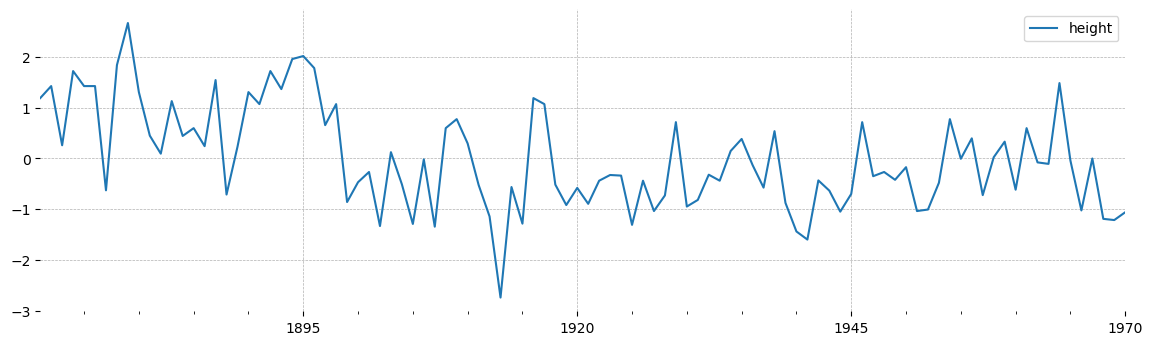

In [2]:
nile = pd.read_csv('data/nile.csv')
nile.index = pd.date_range(start='1871-01-01', end='1970-01-01', freq='AS-Jan')
nile.rename(columns={'x':'height'}, inplace=True)

nile = (nile - nile.mean()) / nile.std()
fig, ax = plt.subplots(figsize=(14,4), dpi=100)
nile.plot(ax=ax)
plt.show()

# Statsmodels.api 

In [3]:
class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Model order
        k_states = k_posdef = 2

        # Initialize the statespace
        super(LocalLinearTrend, self).__init__(
            endog, k_states=k_states, k_posdef=k_posdef,
            initialization='approximate_diffuse',
            loglikelihood_burn=k_states
        )

        # Initialize the matrices
        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1],
                                       [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        # Cache some indices
        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)]*3

    def transform_params(self, unconstrained):
        return unconstrained**2

    def untransform_params(self, constrained):
        return constrained**0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        # Observation covariance
        self.ssm['obs_cov',0,0] = params[0]

        # State covariance
        self.ssm[self._state_cov_idx] = params[1:]

In [4]:
nile_ml = LocalLinearTrend(nile)
res = nile_ml.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 height   No. Observations:                  100
Model:               LocalLinearTrend   Log Likelihood                -127.011
Date:                Sun, 08 May 2022   AIC                            260.022
Time:                        13:39:19   BIC                            267.777
Sample:                    01-01-1871   HQIC                           263.159
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement     0.5125      0.096      5.333      0.000       0.324       0.701
sigma2.level           0.0612      0.042      1.445      0.148      -0.022       0.144
sigma2.trend        1.086e-11      0.000   7.39e-08      1.000      -0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.30   Prob(JB):                         0.98
Heteroskedasticity (H):               0.62   Skew:                             0.05
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [5]:
ml_point_estimates = res.params.values

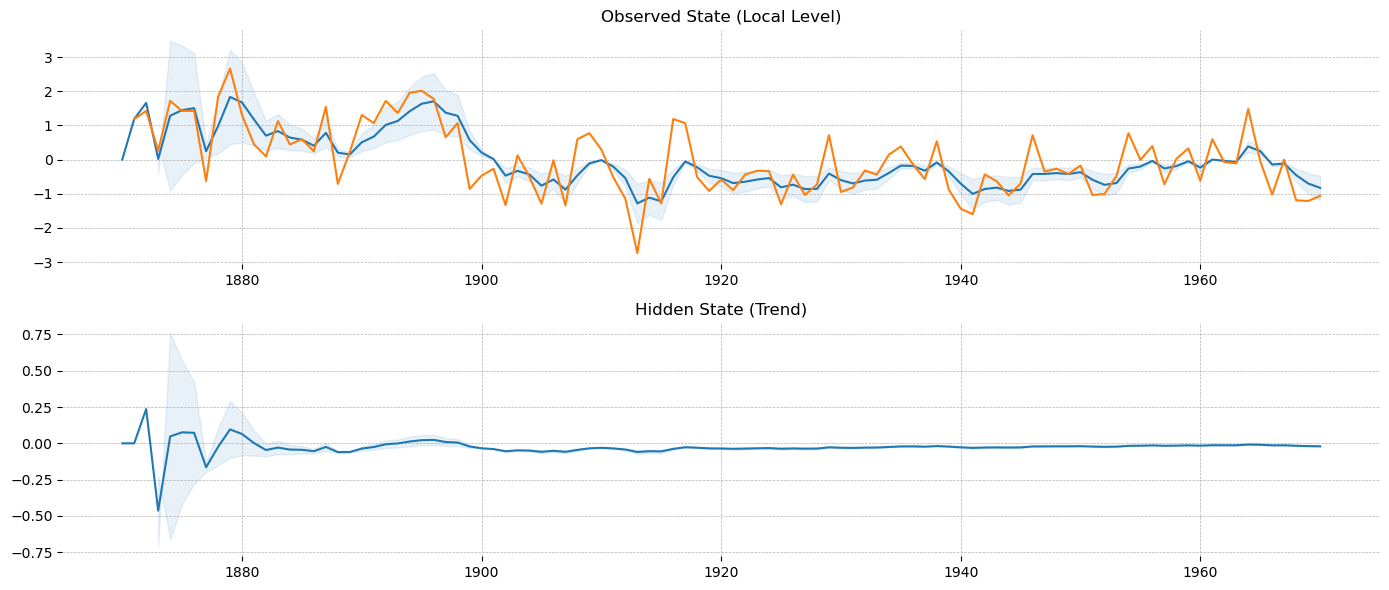

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(14,6), dpi=100)
x_values = nile.index
x_values_plus = pd.date_range(start='1870-01-01', end='1970-01-01', freq='AS-Jan')

state_mean = res.states.predicted.values
state_cov  = res.states.predicted_cov.values.reshape(101, 2, 2)
ci_bounds = 1.96 * np.einsum('tk,tkj->tj', state_mean, state_cov)

upper = state_mean + ci_bounds
lower = state_mean - ci_bounds


ax[0].plot(x_values_plus, state_mean[:, 0])
ax[0].fill_between(x_values[2:], y1=lower[3:, 0], y2=upper[3:, 0], color='tab:blue', alpha=0.1)

ax[0].plot(x_values, nile.values)
ax[0].set(title='Observed State (Local Level)')

ax[1].plot(x_values_plus, state_mean[:, 1])
ax[1].fill_between(x_values[2:], y1=lower[3:, 1], y2=upper[3:, 1], color='tab:blue', alpha=0.1)

ax[1].set(title='Hidden State (Trend)')

fig.tight_layout()
plt.show()

# PyMC

In [7]:
from local_level_model import BayesianLocalLevel

In [8]:
model = BayesianLocalLevel(data=nile.values)

In [9]:
coords = {'time':nile.index.year.values,
          'states':['level', 'trend'],
          'obs':['nile']}

with pm.Model(coords=coords) as nile_model:
    state_sigmas = pm.HalfNormal('state_sigma', sigma=1.0, dims=['states'])
    obs_sigma = pm.HalfNormal('obs_sigma', sigma=1.0, dims=['obs'])

    x0 = pm.Normal('initial_states', mu=0.0, sigma=1.0, dims=['states'])
    initial_sigma = pm.HalfNormal('initial_sigma', sigma=5.0, dims=['states'])
    
    P0 = np.eye(2) * initial_sigma
    
    theta = at.concatenate([x0.ravel(), P0.ravel(), obs_sigma.ravel(), state_sigmas.ravel()])
    model.build_statespace_graph(theta)

    likelihood = pm.Potential("likelihood", model.log_likelihood)
    y_hat = pm.Deterministic('y_hat', model.filtered_states)
    cov_hat = pm.Deterministic('cov_hat', model.filtered_covarainces)
    
    prior_params = pm.sample_prior_predictive(var_names=['y_hat', 'cov_hat'])

C:\Users\Jesse\AppData\Local\Temp\ipykernel_4992\538124040.py:21: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_params = pm.sample_prior_predictive(var_names=['y_hat', 'cov_hat'])
C:\Users\Jesse\miniconda3\envs\pymc_dev\lib\site-packages\pymc\aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
WARNING (aesara.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sur

In [10]:
prior_mean = prior_params.prior['y_hat'].squeeze()
prior_cov = prior_params.prior['cov_hat'].squeeze()

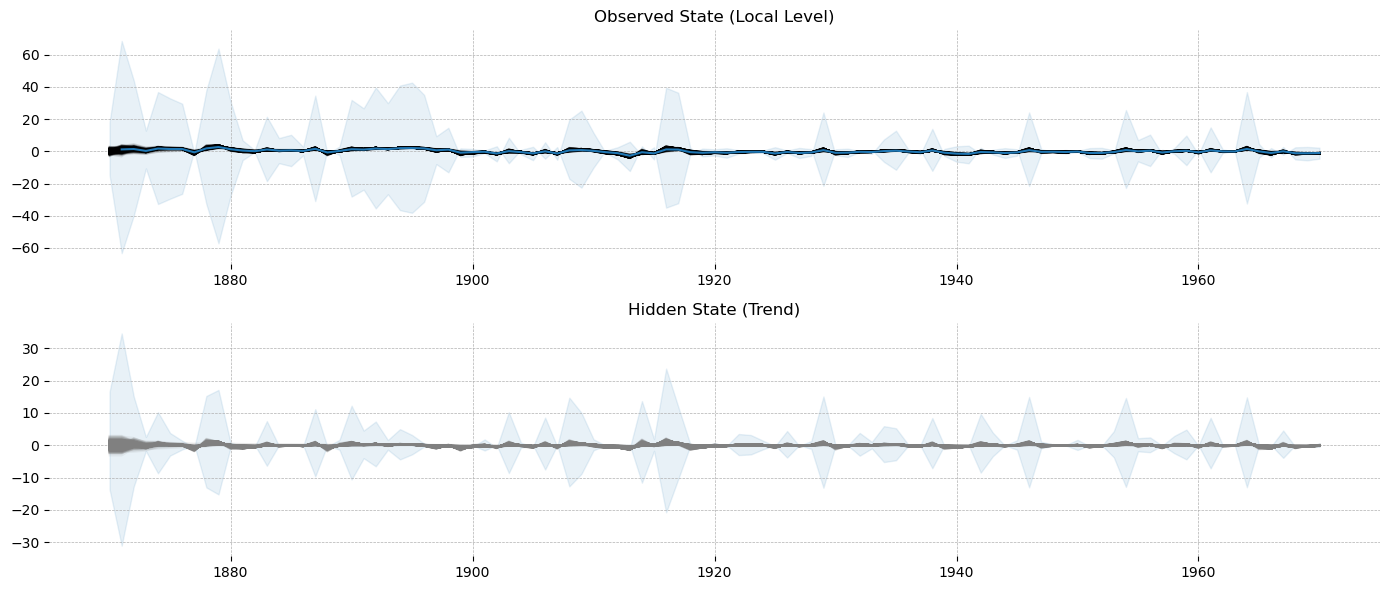

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(14,6), dpi=100)

ci_bounds = 1.96 * np.einsum('stk,stkj->stk', prior_mean, prior_cov)
upper = np.quantile(prior_mean + ci_bounds, 0.95, axis=0)
lower = np.quantile(prior_mean - ci_bounds, 0.05, axis=0)

x_values_plus = pd.date_range(start='1870-01-01', end='1970-01-01', freq='AS-Jan')

ax[0].plot(x_values_plus, prior_mean[:, :, 0].T, color='k', alpha=0.1)
ax[0].fill_between(x_values_plus, y1=lower[:, 0], y2=upper[:, 0], color='tab:blue', alpha=0.1)

ax[0].plot(x_values, nile.values)
ax[0].set(title='Observed State (Local Level)')

ax[1].plot(x_values_plus, prior_mean[:, :, 1].T, color='0.5', alpha=0.1)
ax[1].fill_between(x_values_plus, y1=lower[:, 1], y2=upper[:, 1], color='tab:blue', alpha=0.1)

ax[1].set(title='Hidden State (Trend)')

fig.tight_layout()
plt.show()

In [17]:
with nile_model:
    trace = pm.sample(cores=6, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Jesse\miniconda3\envs\pymc_dev\lib\site-packages\pymc\aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [state_sigma, obs_sigma, initial_states, initial_sigma]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 503 seconds.


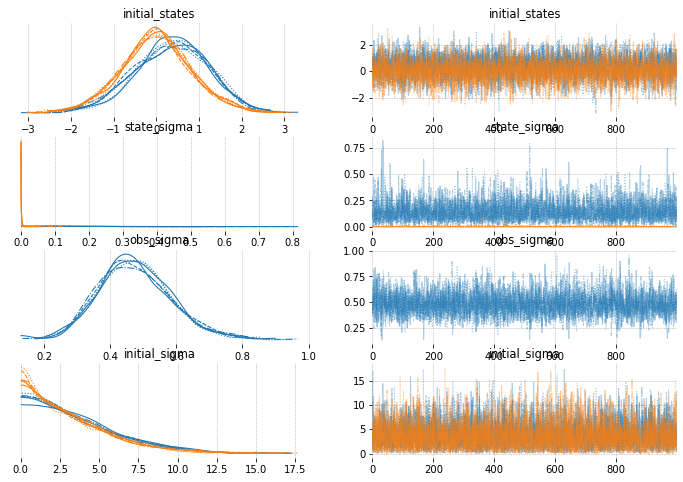

In [36]:
az.plot_trace(trace, var_names=['~y_hat', '~cov_hat']);

In [18]:
az.summary(trace, var_names=['~y_hat', '~cov_hat'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
initial_states[level],0.356,0.863,-1.279,1.929,0.014,0.010,3938.0,4052.0,1.0
initial_states[trend],0.005,0.833,-1.675,1.544,0.014,0.013,3659.0,2886.0,1.0
state_sigma[level],0.136,0.092,0.002,0.298,0.002,0.001,2973.0,2522.0,1.0
state_sigma[trend],0.001,0.003,0.000,0.005,0.000,0.000,3932.0,2518.0,1.0
obs_sigma[nile],0.476,0.110,0.280,0.691,0.002,0.001,3276.0,3414.0,1.0
initial_sigma[level],3.548,2.798,0.016,8.737,0.039,0.027,3411.0,2497.0,1.0
initial_sigma[trend],3.177,2.707,0.002,8.128,0.039,0.028,2767.0,1843.0,1.0


In [20]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 height   No. Observations:                  100
Model:               LocalLinearTrend   Log Likelihood                -127.011
Date:                Sun, 08 May 2022   AIC                            260.022
Time:                        14:27:50   BIC                            267.777
Sample:                    01-01-1871   HQIC                           263.159
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement     0.5125      0.096      5.333      0.000       0.324       0.701
sigma2.level           0.0612      0.042      1.445      0.148      -0.022       0.144
sigma2.trend        1.086e-11      0.000   7.39e-08      1.000      -0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.30   Prob(JB):                         0.98
Heteroskedasticity (H):               0.62   Skew:                             0.05
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

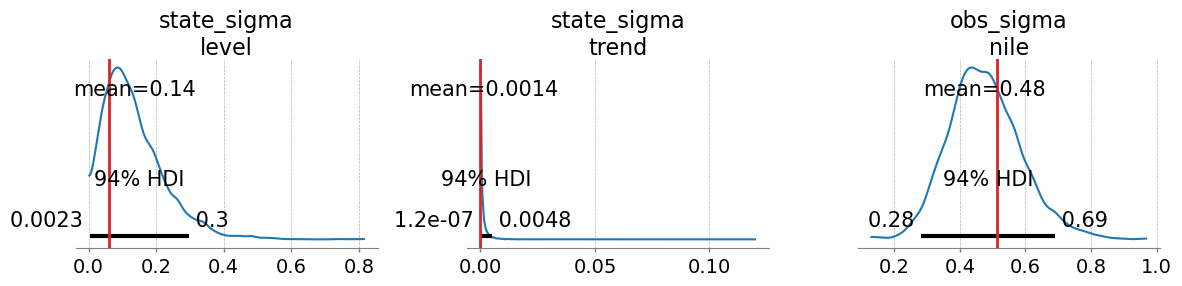

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12,3), dpi=100)
az.plot_posterior(trace, var_names=['state_sigma', 'obs_sigma'], ax=ax)
ax[0].axvline(res.params['sigma2.level'], color='tab:red', lw=2)
ax[1].axvline(res.params['sigma2.trend'], color='tab:red', lw=2)
ax[2].axvline(res.params['sigma2.measurement'], color='tab:red', lw=2)

fig.set(facecolor='white')
fig.tight_layout()
plt.show()

In [22]:
with nile_model:
    post_pred = pm.sample_posterior_predictive(trace, var_names=['y_hat', 'cov_hat'])

C:\Users\Jesse\AppData\Local\Temp\ipykernel_4992\2821760530.py:2: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  post_pred = pm.sample_posterior_predictive(trace, var_names=['y_hat', 'cov_hat'])


In [23]:
post_mean = post_pred.posterior_predictive.stack(dict(idx = ['chain', 'draw']))['y_hat'].squeeze().transpose('idx', 'y_hat_dim_0', 'y_hat_dim_1')
post_cov = post_pred.posterior_predictive.stack(dict(idx = ['chain', 'draw']))['cov_hat'].squeeze().transpose('idx', 'cov_hat_dim_0', 'cov_hat_dim_1', 'cov_hat_dim_2')

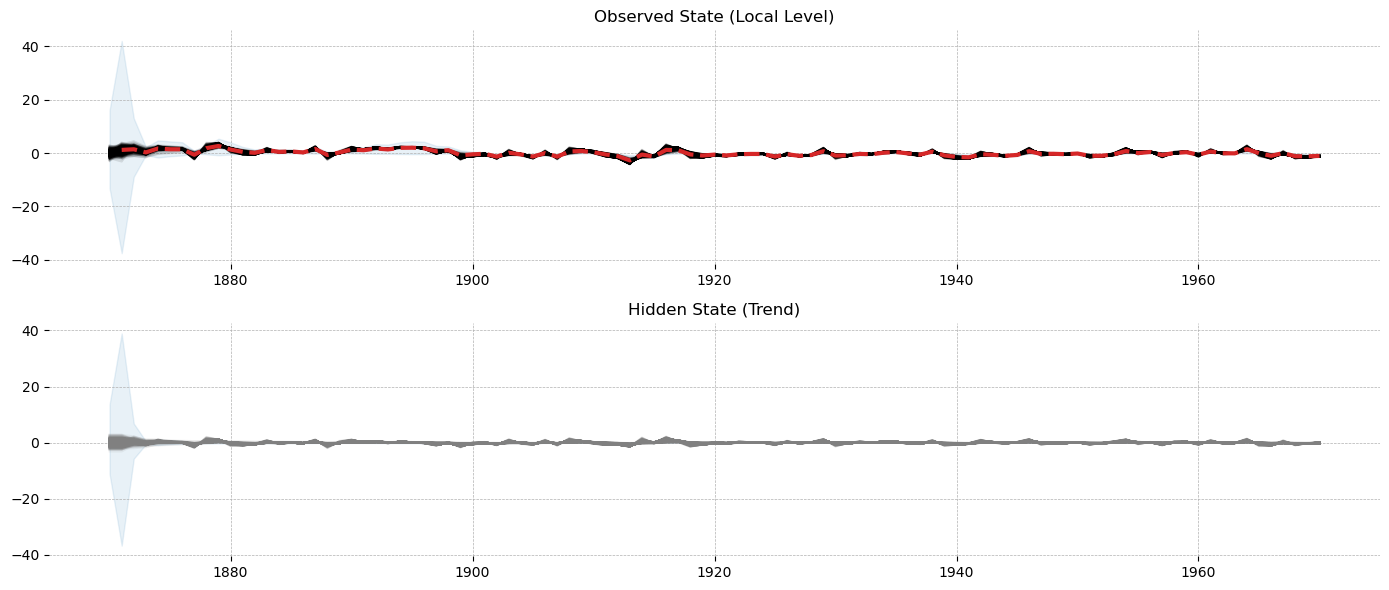

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(14,6), dpi=100)

ci_bounds = 1.96 * np.einsum('stk,stkj->stj', post_mean, post_cov)
upper = np.quantile(post_mean + ci_bounds, 0.95, axis=0)
lower = np.quantile(post_mean - ci_bounds, 0.05, axis=0)

ax[0].plot(x_values_plus, prior_mean[:, :, 0].T, color='k', alpha=0.1)
ax[0].fill_between(x_values_plus, y1=lower[:, 0], y2=upper[:, 0], color='tab:blue', alpha=0.1)

ax[0].plot(x_values, nile.values, color='tab:red', ls='--', lw=3)
ax[0].set(title='Observed State (Local Level)')

ax[1].plot(x_values_plus, prior_mean[:, :, 1].T, color='0.5', alpha=0.1)
ax[1].fill_between(x_values_plus, y1=lower[:, 1], y2=upper[:, 1], color='tab:blue', alpha=0.1)

ax[1].set(title='Hidden State (Trend)')

fig.tight_layout()
plt.show()

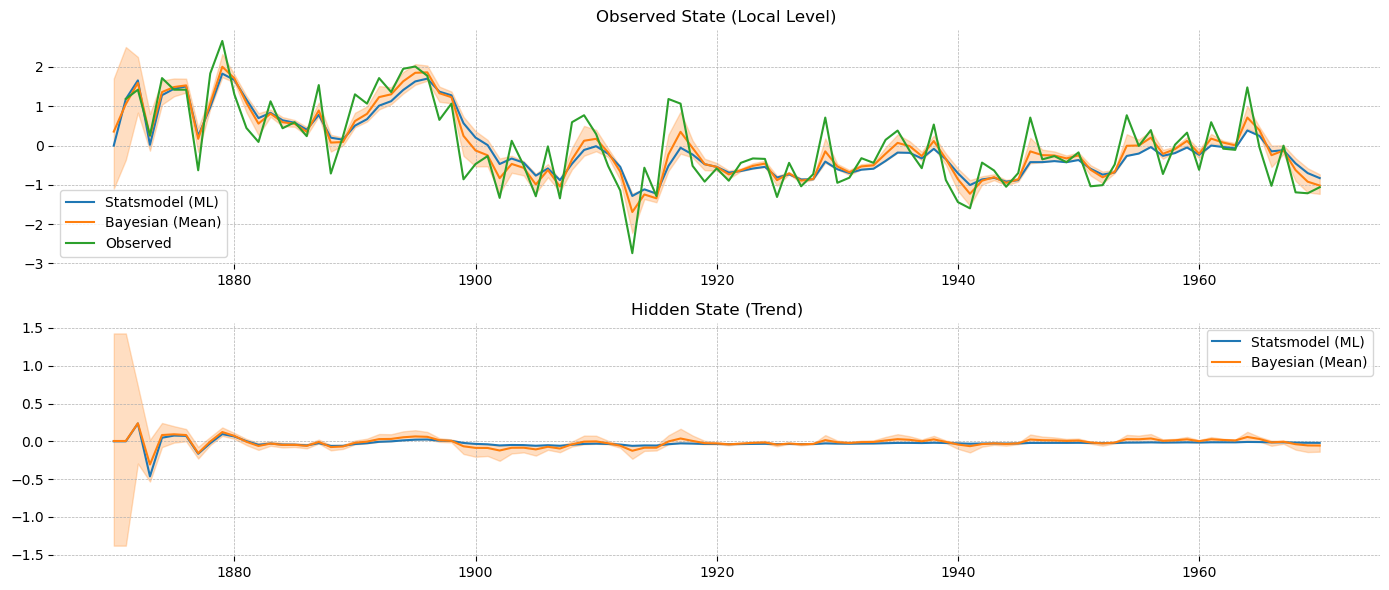

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(14,6), dpi=100)
x_values = nile.index

ax[0].plot(x_values_plus, res.states.predicted.iloc[:, 0], label='Statsmodel (ML)')
ax[0].plot(x_values_plus, post_mean.mean(axis=0)[:, 0], label='Bayesian (Mean)')
ax[0].fill_between(x_values_plus,
                   post_mean.quantile(0.05, dim=['idx'])[:, 0],
                   post_mean.quantile(0.95, dim=['idx'])[:, 0],
                   alpha=0.25, color='tab:orange')
ax[0].plot(x_values, nile.values, label='Observed')
ax[0].set(title='Observed State (Local Level)')
ax[0].legend()

ax[1].plot(x_values_plus, res.states.predicted.iloc[:, 1], label='Statsmodel (ML)')
ax[1].plot(x_values_plus, post_mean.mean(axis=0)[:, 1], label='Bayesian (Mean)')
ax[1].fill_between(x_values_plus,
                   post_mean.quantile(0.05, dim=['idx'])[:, 1],
                   post_mean.quantile(0.95, dim=['idx'])[:, 1],
                   alpha=0.25, color='tab:orange')

ax[1].set(title='Hidden State (Trend)')
ax[1].legend()

fig.set(facecolor='white')
fig.tight_layout()
plt.show()